In [42]:
# import necessary packages
import xarray as xr
from osgeo import gdal
import numpy as np
import pandas as pd
import netCDF4
# import cartopy as ccrs

In [26]:
import xarray as xr
from osgeo import gdal

# Load the original dataset using xarray
ds_landcover = xr.open_dataset('ESACCI-LC-L4-PFT-Map-300m-P1Y-2013-v2.0.8.nc')

# Extract latitude and longitude coordinates
lat = ds_landcover['lat']
lon = ds_landcover['lon']

# Set up GDAL dataset for resampling
gdal_dataset = gdal.Open('ESACCI-LC-L4-PFT-Map-300m-P1Y-2013-v2.0.8.nc')

# Perform the resampling using GDAL
resampled_data = gdal.Warp('resampled_ESACCI-LC-L4-PFT-Map-25km-P1Y-2013-v2.0.8.nc', gdal_dataset, xRes=0.025, yRes=-0.025, resampleAlg=gdal.GRA_NearestNeighbour)

# Close GDAL dataset
gdal_dataset = None

# Create an xarray dataset from the resampled data
resampled_ds = xr.Dataset(
    {'resampled_land_cover': (('lat', 'lon'), resampled_data.ReadAsArray())},  # Read resampled data as array
    coords={'lat': lat, 'lon': lon}
)

# Write the resampled data to a new NetCDF file
resampled_ds.to_netcdf('resampled_ESACCI-LC-L4-PFT-Map-25km-P1Y-2013-v2.0.8.nc')


AttributeError: 'NoneType' object has no attribute 'ReadAsArray'

In [15]:
# Open ESA Landcover classes file
ds_landcover = xr.open_dataset('ESACCI-LC-L4-LCCS-Map-300m-P1Y-2013-v2.0.7b.nc')

lat_min, lat_max = 89, 50
lon_min, lon_max = -170, -50

# slice all data for coords and longer period
ds_landcover = ds_landcover.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

# Save the altered dataset to a new NetCDF file
ds_landcover.to_netcdf('altered_ESACCI-LC-L4-LCCS-Map-300m-P1Y-2013-v2.0.7b.nc')

ds_landcover

<xarray.Dataset>
Dimensions:              (lat: 14040, lon: 43200)
Coordinates:
  * lat                  (lat) float32 89.0 89.0 88.99 88.99 ... 50.01 50.0 50.0
  * lon                  (lon) float32 -170.0 -170.0 -170.0 ... -50.0 -50.0
Data variables:
    lccs_class           (lat, lon) float32 ...
    processed_flag       (lat, lon) float32 ...
    current_pixel_state  (lat, lon) float32 ...
    observation_count    (lat, lon) float32 ...
    change_count         (lat, lon) float32 ...
    crs                  int32 ...
Attributes: (12/38)
    title:                      ESA CCI Land Cover Map
    summary:                    This dataset contains the global ESA CCI land...
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y
    id:                         ESACCI-LC-L4-LCCS-Map-300m-P1Y-2013-v2.0.7
    project:                    Climate Change Initiative - European Space Ag...
    references:                 http://www.esa-landcover-cci.org/
    ...                         ...
    geospatial_lon_max:         180.0
    spatial_resolution:         300m
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.002778
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.002778

In [2]:
# Load the data from the Earth System Data Cube into an xarray dataset
ds_cube = xr.open_dataset('monthly_data_earth_cube.nc')
ds_cube


<xarray.Dataset>
Dimensions:                     (time: 108, lat: 156, lon: 480)
Coordinates:
  * lat                         (lat) float64 50.12 50.38 50.62 ... 88.62 88.88
  * lon                         (lon) float64 -169.9 -169.6 ... -50.38 -50.12
  * time                        (time) datetime64[ns] 2010-01-01 ... 2018-12-01
Data variables:
    burnt_area                  (time, lat, lon) float32 ...
    air_temperature_2m          (time, lat, lon) float32 ...
    precipitation_era5          (time, lat, lon) float32 ...
    kndvi                       (time, lat, lon) float32 ...
    net_radiation               (time, lat, lon) float32 ...
    gross_primary_productivity  (time, lat, lon) float32 ...
    max_air_temperature_2m      (time, lat, lon) float32 ...
Attributes: (12/23)
    Conventions:                CF-1.9
    acknowledgment:             All ESDC data providers are acknowledged insi...
    contributor_name:           ['University of Leipzig', 'Max Planck Institu...
    contributor_url:            ['https://www.uni-leipzig.de/', 'https://www....
    creator_name:               ['University of Leipzig', 'Brockmann Consult ...
    creator_url:                ['https://www.uni-leipzig.de/', 'https://www....
    ...                         ...
    publisher_url:              https://www.earthsystemdatalab.net/
    time_coverage_end:          2021-12-31T00:00:00.000000000
    time_coverage_start:        1979-01-05T00:00:00.000000000
    time_period:                8D
    time_period_reported_day:   5.0
    title:                      Earth System Data Cube (ESDC) v3.0.1

## Create data structure for final plot

create list of numpy arrays
For each pixel two dimensional Numpy array: 
+ First column is the lat coordinate of the pixel
+ Second column is the lon cooridante of the pixel
+ Third column is the % of burnt area of the maxmium month
+ Fourth column: Burnt area
+ Fitht column: Air temperature 2m
+ Sixth column: Precipitation
+ Seventh column: Air temperature 2m max

Rows:
+ First 24 rows are the two years before the fire month
+ 25th row is the fire month: t = 0
+ Next 48 rows are the four years after the the fire

In [3]:
import numpy as np
import xarray as xr

# Load the data from the Earth System Data Cube into an xarray dataset
ds_cube = xr.open_dataset('monthly_data_earth_cube.nc') # dataset with all variables

# Load the burnt area dataset
ds_ba = ds_cube.sel(time=slice('2014', '2015'))  # select the years of interest
ba_monthlyts = ds_ba['burnt_area']  # select the variable of interest
ba_monthlyts_m2 = ba_monthlyts * 10000  # Convert burnt_area unit from hectare to m^2

# Define the threshold for identifying burned pixels
threshold = 0.01  # 1% threshold for identifying burned pixels

# Calculate the total area of each grid cell
R = 6.371e6  # Earth's average radius in meters
dphi = np.deg2rad(0.25)
dlambda = np.deg2rad(0.25)
dlat = R * dphi * xr.ones_like(ds_ba['air_temperature_2m'].lon)
dlon = R * dlambda * xr.ones_like(ds_ba['air_temperature_2m'].lat) * np.cos(np.deg2rad(ds_ba['air_temperature_2m'].lat))
cell_area = dlat * dlon  # unit: m^2

# Calculate the sum of burnt area over the two years
ba_sum = ba_monthlyts_m2.sum(dim='time') 


# Calculate the percentage of burnt area for each grid cell
ba_percentage = (ba_sum * 100) / cell_area

# Identify burned pixels based on the threshold
burned_pixels = ba_percentage > threshold
unburned_pixels = ba_percentage <= threshold

# Add the "burned_pixels" variable to the original dataset
ds_cube['burned_pixel'] = burned_pixels

# Save the modified Dataset back to the .nc file
ds_cube.to_netcdf('monthly_data_earth_cube_with_burned_pixels1.nc')

# Print a message indicating the modified Dataset has been saved
print("Dataset with burned pixels added as a new variable has been saved to 'monthly_data_earth_cube_with_burned_pixels1.nc'.")


Dataset with burned pixels added as a new variable has been saved to 'monthly_data_earth_cube_with_burned_pixels1.nc'.


In [22]:
# load new dataset
ds_burned_pixels = xr.open_dataset('monthly_data_earth_cube_with_burned_pixels1.nc')
ds_burned_pixels

<xarray.Dataset>
Dimensions:                     (time: 108, lat: 156, lon: 480)
Coordinates:
  * lat                         (lat) float64 50.12 50.38 50.62 ... 88.62 88.88
  * lon                         (lon) float64 -169.9 -169.6 ... -50.38 -50.12
  * time                        (time) datetime64[ns] 2010-01-01 ... 2018-12-01
Data variables:
    burnt_area                  (time, lat, lon) float32 ...
    air_temperature_2m          (time, lat, lon) float32 ...
    precipitation_era5          (time, lat, lon) float32 ...
    kndvi                       (time, lat, lon) float32 ...
    net_radiation               (time, lat, lon) float32 ...
    gross_primary_productivity  (time, lat, lon) float32 ...
    max_air_temperature_2m      (time, lat, lon) float32 ...
    burned_pixel                (lat, lon) bool ...
Attributes: (12/23)
    Conventions:                CF-1.9
    acknowledgment:             All ESDC data providers are acknowledged insi...
    contributor_name:           ['University of Leipzig', 'Max Planck Institu...
    contributor_url:            ['https://www.uni-leipzig.de/', 'https://www....
    creator_name:               ['University of Leipzig', 'Brockmann Consult ...
    creator_url:                ['https://www.uni-leipzig.de/', 'https://www....
    ...                         ...
    publisher_url:              https://www.earthsystemdatalab.net/
    time_coverage_end:          2021-12-31T00:00:00.000000000
    time_coverage_start:        1979-01-05T00:00:00.000000000
    time_period:                8D
    time_period_reported_day:   5.0
    title:                      Earth System Data Cube (ESDC) v3.0.1

In [43]:
# prepare kndvi slices with yearly sum for the two years before the wildfire
# Select the data for the year 2012
kndvi_data_2012 = ds_burned_pixels['kndvi'].sel(time=slice('2012-01-01', '2012-12-31'))
kndvi_data_2013 = ds_burned_pixels['kndvi'].sel(time=slice('2013-01-01', '2013-12-31'))

# Compute the sum of kNDVI for the year 2012
kndvi_sum_2012 = kndvi_data_2012.sum(dim='time')
kndvi_sum_2013 = kndvi_data_2013.sum(dim='time')

# Sum statt mean weil Vegetation im Winter sowieso stark zurückgeht - Threshold muss erhöht werden

# Print the maximum value of kndvi_sum_2013 - just to check whether there are actually values in the dataset slice
print("Maximum value of kndvi_sum_2013:", kndvi_sum_2013.values.max())

Maximum value of kndvi_sum_2013: 6.414665


In [25]:
burned_pixels = ds_burned_pixels['burned_pixel']
burned_pixels

<xarray.DataArray 'burned_pixel' (lat: 156, lon: 480)>
[74880 values with dtype=bool]
Coordinates:
  * lat      (lat) float64 50.12 50.38 50.62 50.88 ... 88.12 88.38 88.62 88.88
  * lon      (lon) float64 -169.9 -169.6 -169.4 -169.1 ... -50.62 -50.38 -50.12

In [25]:
# Step 2: Identify unburned controll pixels 

# iterate through pixels that are burned: ds_burned_pixels['burned_pixel'] = True
# search for nearest pixels around that are not burned 
# check whether the difference in kNDVI between the burned_pixel and the nearest pixel that is unburned is less than 0.05
# If the difference is less than 0.05, save their coordinates in a new variable in the .nc file calles 'control_pixel' with true and false. True if the pixel was chosen in this process, false for all other pixels
# otherwise keep searching

# Initialize empty arrays to store control pixel information
# for each burned pixel we store the lat and lon of the according control pixel in the two new variables below
control_pixel_lat = np.zeros_like(ds_burned_pixels['burned_pixel'], dtype=float)
control_pixel_lon = np.zeros_like(ds_burned_pixels['burned_pixel'], dtype=float)
control_pixel = np.zeros_like(ds_burned_pixels['kndvi'], dtype=bool)

burned_pixels = ds_burned_pixels['burned_pixel']

# prepare kndvi slices with yearly sum for the two years before the wildfire
# Select the data for the year 2012
kndvi_data_2012 = ds_burned_pixels['kndvi'].sel(time=slice('2012-01-01', '2012-12-31'))
kndvi_data_2013 = ds_burned_pixels['kndvi'].sel(time=slice('2013-01-01', '2013-12-31'))

# Compute the sum of kNDVI for the year 2012
kndvi_sum_2012 = kndvi_data_2012.sum(dim='time')
kndvi_sum_2013 = kndvi_data_2013.sum(dim='time')


def find_closest_cell(target_lat, target_lon, dataset):
    """
    Find the index of the closest cell in a grid of latitude and longitude values to the target coordinates.
    
    Parameters:
        target_lat (float): Latitude of the target cell.
        target_lon (float): Longitude of the target cell.
        dataset (netCDF4.Dataset): NetCDF dataset containing latitude and longitude variables.
    
    Returns:
        lat_idx (int): Index of the closest latitude value in the grid.
        lon_idx (int): Index of the closest longitude value in the grid.
    """
    # Extract latitude and longitude arrays from the dataset
    lats = dataset.variables['lat'][:]
    lons = dataset.variables['lon'][:]
    
    # Find the index of the closest latitude value
    lat_idx = np.where(np.abs(target_lat - lats) == np.nanmin(np.abs(target_lat - lats)))[0][0]
    # Find the index of the closest longitude value
    lon_idx = np.where(np.abs(target_lon - lons) == np.nanmin(np.abs(target_lon - lons)))[0][0]
    
    return lat_idx, lon_idx


# np.where(np.abs(in_lat-lats)==np.nanmin(np.abs(in_lat-lats))) 

# iterate through the cells of burned_pixels where the value is True
# for each cell call the find_closest_cell function (with the coordinates of the respective cell you are looking at at that step of the loop)
# check whether the kndvi_sum_2013 of the burned cell (cell where burned_pixels is True) and the kndvi_sum_2013 of the nearest cell (we found that with the function above) have a difference of less than 0.05
# do the same for kndvi_sum_2012 
# If both conditions are fulfilled then save the lat of the control_pixel we just found in control_pixel_lat as a float and do it at the place (lat, lon) of the respective burned_pixel
# save the lon of the control_pixel we just found in control_pixel_lon as a float and do it at the place (lat, lon) of the respective burned_pixel



# Save the control pixel information back to the dataset

ds_burned_pixels['control_pixel_lat'] = (('lat', 'lon'), control_pixel)
ds_burned_pixels['control_pixel_lon'] = (('lat', 'lon'), control_pixel)

# Save the modified dataset
ds_burned_pixels.to_netcdf('monthly_data_earth_cube_with_control_pixels.nc')



IndexError: index 185 is out of bounds for axis 1 with size 156

In [27]:
# Works but only looks for closest cell and if that's not fulfilling the conditions, then I think there's no control cell at all
import numpy as np
import netCDF4

# Initialize lists to store pixel coordinates
burned_pixel_lat = []
burned_pixel_lon = []
control_pixel_lat = []
control_pixel_lon = []


# Define the function to find the closest cell
def find_closest_cells(target_lat, target_lon, dataset):

    # Extract latitude and longitude arrays from the dataset
    lats = dataset.variables['lat'][:]
    lons = dataset.variables['lon'][:]
    
    # Find the index of the closest latitude value
    lat_idx = np.where(np.abs(target_lat - lats) == np.nanmin(np.abs(target_lat - lats)))[0][0]
    
    # Find the index of the closest longitude value
    lon_idx = np.where(np.abs(target_lon - lons) == np.nanmin(np.abs(target_lon - lons)))[0][0]
    
    return lat_idx, lon_idx

# Step 2: Iterate through burned pixels and identify unburned control pixels

# Initialize empty arrays to store control pixel information
control_pixel_lat = np.zeros_like(ds_burned_pixels['burned_pixel'], dtype=float)
control_pixel_lon = np.zeros_like(ds_burned_pixels['burned_pixel'], dtype=float)
control_pixel = np.zeros_like(ds_burned_pixels['burned_pixel'], dtype=bool)

burned_pixels = ds_burned_pixels['burned_pixel']

# prepare kndvi slices with yearly sum for the two years before the wildfire
# Select the data for the year 2012
kndvi_data_2012 = ds_burned_pixels['kndvi'].sel(time=slice('2012-01-01', '2012-12-31'))
kndvi_data_2013 = ds_burned_pixels['kndvi'].sel(time=slice('2013-01-01', '2013-12-31'))

# Compute the sum of kNDVI for the year 2012
kndvi_sum_2012 = kndvi_data_2012.sum(dim='time')
kndvi_sum_2013 = kndvi_data_2013.sum(dim='time')

# Iterate through the burned pixels
for lat_idx, lon_idx in np.ndindex(ds_burned_pixels.shape):
    if burned_pixels[lat_idx, lon_idx]:  # Check if the pixel is burned
        # Find the closest unburned cell
        closest_lat_idx, closest_lon_idx = find_closest_cells(lat_idx, lon_idx, ds_burned_pixels)
        
        # Check the difference in kNDVI for both years
        if np.abs(kndvi_sum_2012[lat_idx, lon_idx] - kndvi_sum_2012[closest_lat_idx, closest_lon_idx]) < 0.5 \
                and np.abs(kndvi_sum_2013[lat_idx, lon_idx] - kndvi_sum_2013[closest_lat_idx, closest_lon_idx]) < 0.5:
            # Save the coordinates of the control pixel
            control_pixel[closest_lat_idx, closest_lon_idx] = True
            # For each burned pixel we store the lat and lon of the according control pixel in the two new variables below
            control_pixel_lat[lat_idx, lon_idx] = ds_burned_pixels['lat'][closest_lat_idx]  
            control_pixel_lon[lat_idx, lon_idx] = ds_burned_pixels['lon'][closest_lon_idx]

# Save the control pixel information back to the dataset
ds_burned_pixels['control_pixel'] = (('lat', 'lon'), control_pixel)
ds_burned_pixels['control_pixel_lat'] = (('lat', 'lon'), control_pixel_lat)
ds_burned_pixels['control_pixel_lon'] = (('lat', 'lon'), control_pixel_lon)

# Save the modified dataset
ds_burned_pixels.to_netcdf('monthly_data_earth_cube_with_control_pixels.nc')




In [ ]:
import numpy as np
import pandas as pd
import xarray as xr

# Load the dataset
ds_burned_pixels = xr.open_dataset('monthly_data_earth_cube_with_burned_pixels1.nc')

# Extract burned_pixel array
burned_pixels = ds_burned_pixels['burned_pixel'].values

# Get lat and lon coordinates
lat = ds_burned_pixels['lat'].values
lon = ds_burned_pixels['lon'].values

# Define the function to find the closest unburned cell within a radius
def find_closest_unburned_cells(lat_idx, lon_idx, burned_pixels, kndvi_sum_2012, kndvi_sum_2013, max_radius):
    radius = 1
    while radius <= max_radius:
        for di in range(-radius, radius + 1):
            for dj in range(-radius, radius + 1):
                if 0 <= lat_idx + di < len(lat) and 0 <= lon_idx + dj < len(lon) \
                        and not burned_pixels[lat_idx + di, lon_idx + dj]:
                    # Check the difference in kNDVI for both years
                    if np.abs(kndvi_sum_2012[lat_idx, lon_idx] - kndvi_sum_2012[lat_idx + di, lon_idx + dj]) < 0.5 \
                            and np.abs(kndvi_sum_2013[lat_idx, lon_idx] - kndvi_sum_2013[lat_idx + di, lon_idx + dj]) < 0.5:
                        return lat_idx + di, lon_idx + dj
        radius += 1
    return None, None

# Initialize lists to store pixel coordinates
burned_pixel_lat = []
burned_pixel_lon = []
control_pixel_lat = []
control_pixel_lon = []

# Maximum radius to search for unburned control cells
max_radius = 5  # Adjust as needed

# kndvi_sum_2012 
# kndvi_sum_2013 

# Step 2: Iterate through burned pixels and identify unburned control pixels

# prepare kndvi slices with yearly sum for the two years before the wildfire
# Select the data for the year 2012
kndvi_data_2012 = ds_burned_pixels['kndvi'].sel(time=slice('2012-01-01', '2012-12-31'))
kndvi_data_2013 = ds_burned_pixels['kndvi'].sel(time=slice('2013-01-01', '2013-12-31'))

# Compute the sum of kNDVI for the year 2012
kndvi_sum_2012 = kndvi_data_2012.sum(dim='time')
kndvi_sum_2013 = kndvi_data_2013.sum(dim='time')

# Iterate through all burned pixels in the dataset
for lat_idx, lon_idx in np.ndindex(burned_pixels.shape):
    if burned_pixels[lat_idx, lon_idx]:  # Check if the pixel is burned
        burned_pixel_lat.append(lat[lat_idx])
        burned_pixel_lon.append(lon[lon_idx])
        # Find the closest unburned cell within the maximum radius
        closest_unburned_lat, closest_unburned_lon = find_closest_unburned_cells(lat_idx, lon_idx, burned_pixels, kndvi_sum_2012, kndvi_sum_2013, max_radius)
        if closest_unburned_lat is not None and closest_unburned_lon is not None:
            # Save the coordinates of the control pixel
            control_pixel_lat.append(lat[closest_unburned_lat])
            control_pixel_lon.append(lon[closest_unburned_lon])

# Create a DataFrame to store pixel coordinates
pixel_data = {
    'burned_lat': burned_pixel_lat,
    'burned_lon': burned_pixel_lon,
    'control_lat': control_pixel_lat,
    'control_lon': control_pixel_lon
}
pixels_df = pd.DataFrame(pixel_data)

# Save the DataFrame to a CSV file
pixels_df.to_csv('burned_and_control_pixels.csv', index=False)


WORKS (seemingly)

In [79]:
import numpy as np
import pandas as pd
import xarray as xr

# prepare kndvi slices with yearly sum for the two years before the wildfire
# Select the data for the year 2012
kndvi_data_2012 = ds_burned_pixels['kndvi'].sel(time=slice('2012-01-01', '2012-12-31'))
kndvi_data_2013 = ds_burned_pixels['kndvi'].sel(time=slice('2013-01-01', '2013-12-31'))

# Compute the sum of kNDVI for the year 2012
kndvi_sum_2012 = kndvi_data_2012.sum(dim='time')
kndvi_sum_2013 = kndvi_data_2013.sum(dim='time')

# prepare gpp slices with yearly sum for the two years before the wildfire
# Select the data for the year 2012
gpp_data_2012 = ds_burned_pixels['gross_primary_productivity'].sel(time=slice('2012-01-01', '2012-12-31'))
gpp_data_2013 = ds_burned_pixels['gross_primary_productivity'].sel(time=slice('2013-01-01', '2013-12-31'))

# Compute the sum of gpp for the year 2012
gpp_sum_2012 = gpp_data_2012.sum(dim='time')
gpp_sum_2013 = gpp_data_2013.sum(dim='time')


# Load the dataset
ds_burned_pixels = xr.open_dataset('monthly_data_earth_cube_with_burned_pixels1.nc')

# Extract burned_pixel array
burned_pixels = ds_burned_pixels['burned_pixel'].values

# Get lat and lon coordinates
lat = ds_burned_pixels['lat'].values
lon = ds_burned_pixels['lon'].values

# Define the function to find the closest unburned cell within a radius
def find_closest_unburned_cells(lat_idx, lon_idx, burned_pixels, max_radius):
    radius = 1
    while radius <= max_radius:
        for di in range(-radius, radius + 1):
            for dj in range(-radius, radius + 1):
                if 0 <= lat_idx + di < len(lat) and 0 <= lon_idx + dj < len(lon) \
                        and np.abs(kndvi_sum_2012[lat_idx, lon_idx] - kndvi_sum_2012[lat_idx + di, lon_idx + dj]) < 0.6 \
                            and np.abs(kndvi_sum_2013[lat_idx, lon_idx] - kndvi_sum_2013[lat_idx + di, lon_idx + dj]) < 0.6 \
                            and not burned_pixels[lat_idx + di, lon_idx + dj]:
                                #and np.abs(gpp_data_2012[lat_idx, lon_idx] - gpp_data_2012[lat_idx + di, lon_idx + dj]) < 2.4 \
                                    #and np.abs(gpp_data_2013[lat_idx, lon_idx] - gpp_data_2013[lat_idx + di, lon_idx + dj]) < 2.4 \
                                #and not burned_pixels[lat_idx + di, lon_idx + dj]:
                
                    return lat_idx + di, lon_idx + dj
                    
        radius += 1
    return None, None

# Initialize lists to store pixel coordinates
burned_pixel_lat = []
burned_pixel_lon = []
control_pixel_lat = []
control_pixel_lon = []

# Maximum radius to search for unburned control cells
max_radius = 5  # Adjust as needed

# Iterate through all burned pixels in the dataset
for lat_idx, lon_idx in np.ndindex(burned_pixels.shape):
    if burned_pixels[lat_idx, lon_idx]:  # Check if the pixel is burned
        burned_pixel_lat.append(lat[lat_idx])
        burned_pixel_lon.append(lon[lon_idx])
        # Find the closest unburned cell within the maximum radius
        closest_unburned_lat, closest_unburned_lon = find_closest_unburned_cells(lat_idx, lon_idx, burned_pixels, max_radius)
        if closest_unburned_lat is not None and closest_unburned_lon is not None:
            control_pixel_lat.append(lat[closest_unburned_lat])
            control_pixel_lon.append(lon[closest_unburned_lon])

        else:
            control_pixel_lat.append(np.nan)
            control_pixel_lon.append(np.nan)

# Create a DataFrame to store pixel coordinates
pixel_data = {
    'burned_lat': burned_pixel_lat,
    'burned_lon': burned_pixel_lon,
    'control_lat': control_pixel_lat,
    'control_lon': control_pixel_lon
}
pixels_df = pd.DataFrame(pixel_data)

# Save the DataFrame to a CSV file
pixels_df.to_csv('burned_and_control_pixels2.csv', index=False)


newest attempt (1642)

In [82]:
import numpy as np
import pandas as pd
import xarray as xr

# prepare kndvi slices with yearly sum for the two years before the wildfire
# Select the data for the year 2012
kndvi_data_2012 = ds_burned_pixels['kndvi'].sel(time=slice('2012-01-01', '2012-12-31'))
kndvi_data_2013 = ds_burned_pixels['kndvi'].sel(time=slice('2013-01-01', '2013-12-31'))

# Compute the sum of kNDVI for the year 2012
kndvi_sum_2012 = kndvi_data_2012.sum(dim='time')
kndvi_sum_2013 = kndvi_data_2013.sum(dim='time')

# prepare gpp slices with yearly sum for the two years before the wildfire
# Select the data for the year 2012
gpp_data_2012 = ds_burned_pixels['gross_primary_productivity'].sel(time=slice('2012-01-01', '2012-12-31'))
gpp_data_2013 = ds_burned_pixels['gross_primary_productivity'].sel(time=slice('2013-01-01', '2013-12-31'))

# Compute the sum of gpp for the year 2012
gpp_sum_2012 = gpp_data_2012.sum(dim='time')
gpp_sum_2013 = gpp_data_2013.sum(dim='time')

# prepare net radiation slices with yearly sum for the two years before the wildfire
# Select the data for the year 2012
rn_data_2012 = ds_burned_pixels['net_radiation'].sel(time=slice('2012-01-01', '2012-12-31'))
rn_data_2013 = ds_burned_pixels['net_radiation'].sel(time=slice('2013-01-01', '2013-12-31'))

# Compute the sum of net radiation for the year 2012
rn_mean_2012 = rn_data_2012.mean(dim='time')
rn_mean_2013 = rn_data_2013.mean(dim='time')


# Load the dataset
ds_burned_pixels = xr.open_dataset('monthly_data_earth_cube_with_burned_pixels1.nc')

# Extract burned_pixel array
burned_pixels = ds_burned_pixels['burned_pixel'].values

# Get lat and lon coordinates
lat = ds_burned_pixels['lat'].values
lon = ds_burned_pixels['lon'].values

# Define the function to find the closest unburned cell within a radius
def find_closest_unburned_cells(lat_idx, lon_idx, burned_pixels, max_radius):
    radius = 1
    while radius <= max_radius:
        for di in range(-radius, radius + 1):
            for dj in range(-radius, radius + 1):
                if 0 <= lat_idx + di < len(lat) and 0 <= lon_idx + dj < len(lon) \
                        and np.abs(kndvi_sum_2012[lat_idx, lon_idx] - kndvi_sum_2012[lat_idx + di, lon_idx + dj]) < 0.6 \
                        and np.abs(kndvi_sum_2013[lat_idx, lon_idx] - kndvi_sum_2013[lat_idx + di, lon_idx + dj]) < 0.6 \
                        and not burned_pixels[lat_idx + di, lon_idx + dj] \
                        and np.abs(gpp_sum_2012[lat_idx, lon_idx] - gpp_sum_2012[lat_idx + di, lon_idx + dj]) < 2.4 \
                        and np.abs(gpp_sum_2013[lat_idx, lon_idx] - gpp_sum_2013[lat_idx + di, lon_idx + dj]) < 2.4 \
                        and np.abs(rn_mean_2012[lat_idx, lon_idx] - rn_mean_2012[lat_idx + di, lon_idx + dj]) < 0.2 \
                        and np.abs(rn_mean_2013[lat_idx, lon_idx] - rn_mean_2013[lat_idx + di, lon_idx + dj]) < 0.2:
                    
                    return lat_idx + di, lon_idx + dj
                    
        radius += 1
    return None, None


# Initialize lists to store pixel coordinates
burned_pixel_lat = []
burned_pixel_lon = []
control_pixel_lat = []
control_pixel_lon = []

# Maximum radius to search for unburned control cells
max_radius = 5  # Adjust as needed

# Iterate through all burned pixels in the dataset
for lat_idx, lon_idx in np.ndindex(burned_pixels.shape):
    if burned_pixels[lat_idx, lon_idx]:  # Check if the pixel is burned
        burned_pixel_lat.append(lat[lat_idx])
        burned_pixel_lon.append(lon[lon_idx])
        # Find the closest unburned cell within the maximum radius
        closest_unburned_lat, closest_unburned_lon = find_closest_unburned_cells(lat_idx, lon_idx, burned_pixels, max_radius)
        if closest_unburned_lat is not None and closest_unburned_lon is not None:
            control_pixel_lat.append(lat[closest_unburned_lat])
            control_pixel_lon.append(lon[closest_unburned_lon])

        else:
            control_pixel_lat.append(np.nan)
            control_pixel_lon.append(np.nan)

# Create a DataFrame to store pixel coordinates
pixel_data = {
    'burned_lat': burned_pixel_lat,
    'burned_lon': burned_pixel_lon,
    'control_lat': control_pixel_lat,
    'control_lon': control_pixel_lon
}
pixels_df = pd.DataFrame(pixel_data)

# Save the DataFrame to a CSV file
pixels_df.to_csv('burned_and_control_pixels2.csv', index=False)


In [83]:
import numpy as np
import pandas as pd
import xarray as xr

# prepare kndvi slices with yearly sum for the two years before the wildfire
# Select the data for the year 2012
kndvi_data_2012 = ds_burned_pixels['kndvi'].sel(time=slice('2012-01-01', '2012-12-31'))
kndvi_data_2013 = ds_burned_pixels['kndvi'].sel(time=slice('2013-01-01', '2013-12-31'))

# Compute the sum of kNDVI for the year 2012
kndvi_sum_2012 = kndvi_data_2012.sum(dim='time')
kndvi_sum_2013 = kndvi_data_2013.sum(dim='time')

# prepare air temp slices with yearly sum for the two years before the wildfire
# Select the data for the year 2012
airtemp_data_2012 = ds_burned_pixels['air_temperature_2m'].sel(time=slice('2012-01-01', '2012-12-31'))
airtemp_data_2013 = ds_burned_pixels['air_temperature_2m'].sel(time=slice('2013-01-01', '2013-12-31'))

# Compute the sum of kNDVI for the year 2012
airtemp_mean_2012 = airtemp_data_2012.mean(dim='time')
airtemp_mean_2013 = airtemp_data_2013.mean(dim='time')

# prepare net radiation slices with yearly sum for the two years before the wildfire
# Select the data for the year 2012
rn_data_2012 = ds_burned_pixels['net_radiation'].sel(time=slice('2012-01-01', '2012-12-31'))
rn_data_2013 = ds_burned_pixels['net_radiation'].sel(time=slice('2013-01-01', '2013-12-31'))

# Compute the sum of net radiation for the year 2012
rn_mean_2012 = rn_data_2012.mean(dim='time')
rn_mean_2013 = rn_data_2013.mean(dim='time')

# prepare gpp slices with yearly sum for the two years before the wildfire
# Select the data for the year 2012
gpp_data_2012 = ds_burned_pixels['gross_primary_productivity'].sel(time=slice('2012-01-01', '2012-12-31'))
gpp_data_2013 = ds_burned_pixels['gross_primary_productivity'].sel(time=slice('2013-01-01', '2013-12-31'))

# Compute the sum of gpp for the year 2012
gpp_sum_2012 = gpp_data_2012.sum(dim='time')
gpp_sum_2013 = gpp_data_2013.sum(dim='time')



# Load the dataset
ds_burned_pixels = xr.open_dataset('monthly_data_earth_cube_with_burned_pixels1.nc')

# Extract burned_pixel array
burned_pixels = ds_burned_pixels['burned_pixel'].values

# Get lat and lon coordinates
lat = ds_burned_pixels['lat'].values
lon = ds_burned_pixels['lon'].values

# Define the function to find the closest unburned cell within a radius
def find_closest_unburned_cells(lat_idx, lon_idx, burned_pixels, max_radius):
    radius = 1
    while radius <= max_radius:
        for di in range(-radius, radius + 1):
            for dj in range(-radius, radius + 1):
                if 0 <= lat_idx + di < len(lat) and 0 <= lon_idx + dj < len(lon) \
                        and not burned_pixels[lat_idx + di, lon_idx + dj] \
                        and np.abs(kndvi_sum_2012[lat_idx, lon_idx] - kndvi_sum_2012[lat_idx + di, lon_idx + dj]) < 0.6 \
                        and np.abs(kndvi_sum_2013[lat_idx, lon_idx] - kndvi_sum_2013[lat_idx + di, lon_idx + dj]) < 0.6 \
                        and np.abs(gpp_sum_2012[lat_idx, lon_idx] - gpp_sum_2012[lat_idx + di, lon_idx + dj]) < 2.4 \
                        and np.abs(gpp_sum_2013[lat_idx, lon_idx] - gpp_sum_2013[lat_idx + di, lon_idx + dj]) < 2.4 \
                        and np.abs(rn_mean_2012[lat_idx, lon_idx] - rn_mean_2012[lat_idx + di, lon_idx + dj]) < 0.2 \
                        and np.abs(rn_mean_2013[lat_idx, lon_idx] - rn_mean_2013[lat_idx + di, lon_idx + dj]) < 0.2 \
                        and np.abs(airtemp_mean_2012[lat_idx, lon_idx] - airtemp_mean_2012[lat_idx + di, lon_idx + dj]) < 0.2 \
                        and np.abs(airtemp_mean_2013[lat_idx, lon_idx] - airtemp_mean_2013[lat_idx + di, lon_idx + dj]) < 0.2:
                    
                    return lat_idx + di, lon_idx + dj
                    
        radius += 1
    return None, None


# Initialize lists to store pixel coordinates
burned_pixel_lat = []
burned_pixel_lon = []
control_pixel_lat = []
control_pixel_lon = []

# Maximum radius to search for unburned control cells
max_radius = 5  # Adjust as needed

# Iterate through all burned pixels in the dataset
for lat_idx, lon_idx in np.ndindex(burned_pixels.shape):
    if burned_pixels[lat_idx, lon_idx]:  # Check if the pixel is burned
        burned_pixel_lat.append(lat[lat_idx])
        burned_pixel_lon.append(lon[lon_idx])
        # Find the closest unburned cell within the maximum radius
        closest_unburned_lat, closest_unburned_lon = find_closest_unburned_cells(lat_idx, lon_idx, burned_pixels, max_radius)
        if closest_unburned_lat is not None and closest_unburned_lon is not None:
            control_pixel_lat.append(lat[closest_unburned_lat])
            control_pixel_lon.append(lon[closest_unburned_lon])

        else:
            control_pixel_lat.append(np.nan)
            control_pixel_lon.append(np.nan)

# Create a DataFrame to store pixel coordinates
pixel_data = {
    'burned_lat': burned_pixel_lat,
    'burned_lon': burned_pixel_lon,
    'control_lat': control_pixel_lat,
    'control_lon': control_pixel_lon
}
pixels_df = pd.DataFrame(pixel_data)

# Save the DataFrame to a CSV file
pixels_df.to_csv('burned_and_control_pixels2.csv', index=False)


evaluate changes in air temp for burned pixel and respective control pixel (same for precipitation)

Steps:
* Loop through all burned pixels 
* find out timing of fire (t=0) -> wann hat es zum letzten Mal gebrannt? Seid wann ist burned_area < threshold (Allerdings haben wir diesen Step bei den vorherigen Schritten nicht gemacht)
* 
* for 1-24 months after fire (t=1 - t=24): (wir müssen eig nicht mehr monatliche means vergleichen, weil wir ja eh schon auf monatlich geresamplet haben)
    burned_pixel[air_temp].sel(lat,lon) - control_pixel[air_temp].sel[respective controlpixel lat, lon]


    * save die Differenzen zw. burned und respective control pixel einer zwischenvariable um dann darüber den mittelwert zu bilden?
    

    * burned area kategorien: 0.2 - 0.4, 0.4 - 0.6, 0.6 - 0.8, > 0.8 -> mit jährlichen burned_sum berechnen
    -> burned area max ansehen
-----

* fire severity:
    - Klassifizierung der severity in 5 Kategorien und dann nochmal differences für diese kategorien?
    - 

* alternative nur pixel mit hoher burned area (zB 80%) für analyse verwerten







WORKS!!!!!!!!

In [88]:
import numpy as np
import pandas as pd
import xarray as xr
####################### WORKS ################################
"""
# prepare kndvi slices with yearly sum for the two years before the wildfire
# Select the data for the year 2012
kndvi_data_2012 = ds_burned_pixels['kndvi'].sel(time=slice('2012-01-01', '2012-12-31'))
kndvi_data_2013 = ds_burned_pixels['kndvi'].sel(time=slice('2013-01-01', '2013-12-31'))

# Compute the sum of kNDVI for the year 2012
kndvi_sum_2012 = kndvi_data_2012.sum(dim='time')
kndvi_sum_2013 = kndvi_data_2013.sum(dim='time')

# prepare air temp slices with yearly sum for the two years before the wildfire
# Select the data for the year 2012
airtemp_data_2012 = ds_burned_pixels['air_temperature_2m'].sel(time=slice('2012-01-01', '2012-12-31'))
airtemp_data_2013 = ds_burned_pixels['air_temperature_2m'].sel(time=slice('2013-01-01', '2013-12-31'))

# Compute the sum of kNDVI for the year 2012
airtemp_mean_2012 = airtemp_data_2012.mean(dim='time')
airtemp_mean_2013 = airtemp_data_2013.mean(dim='time')

# prepare net radiation slices with yearly sum for the two years before the wildfire
# Select the data for the year 2012
rn_data_2012 = ds_burned_pixels['net_radiation'].sel(time=slice('2012-01-01', '2012-12-31'))
rn_data_2013 = ds_burned_pixels['net_radiation'].sel(time=slice('2013-01-01', '2013-12-31'))

# Compute the sum of net radiation for the year 2012
rn_mean_2012 = rn_data_2012.mean(dim='time')
rn_mean_2013 = rn_data_2013.mean(dim='time')

# prepare gpp slices with yearly sum for the two years before the wildfire
# Select the data for the year 2012
gpp_data_2012 = ds_burned_pixels['gross_primary_productivity'].sel(time=slice('2012-01-01', '2012-12-31'))
gpp_data_2013 = ds_burned_pixels['gross_primary_productivity'].sel(time=slice('2013-01-01', '2013-12-31'))

# Compute the sum of gpp for the year 2012
gpp_sum_2012 = gpp_data_2012.sum(dim='time')
gpp_sum_2013 = gpp_data_2013.sum(dim='time')
"""

# Load the datasets
ds_burned_pixels = xr.open_dataset('monthly_data_earth_cube_with_burned_pixels1.nc')

ds_landcover_type = xr.open_dataset('ESA_LC.nc')

# Extract burned_pixel array
burned_pixels = ds_burned_pixels['burned_pixel'].values

# Get lat and lon coordinates
lat = ds_burned_pixels['lat'].values
lon = ds_burned_pixels['lon'].values

# Define the function to find the closest unburned cell within a radius
def find_closest_unburned_cells(lat_idx, lon_idx, burned_pixels, max_radius):
    radius = 1
    while radius <= max_radius:
        for di in range(-radius, radius + 1):
            for dj in range(-radius, radius + 1):
                if 0 <= lat_idx + di < len(lat) and 0 <= lon_idx + dj < len(lon) \
                        and not burned_pixels[lat_idx + di, lon_idx + dj] \
                        and ds_landcover_type['Band1'].sel(lat=lat_idx, lon=lon_idx, method='nearest').item() == \
                            ds_landcover_type['Band1'].sel(lat=lat_idx + di, lon=lon_idx + dj, method='nearest').item() \
                        and np.abs(kndvi_sum_2012[lat_idx, lon_idx] - kndvi_sum_2012[lat_idx + di, lon_idx + dj]) < 0.6 \
                        and np.abs(kndvi_sum_2013[lat_idx, lon_idx] - kndvi_sum_2013[lat_idx + di, lon_idx + dj]) < 0.6 \
                        and np.abs(gpp_sum_2012[lat_idx, lon_idx] - gpp_sum_2012[lat_idx + di, lon_idx + dj]) < 2.4 \
                        and np.abs(gpp_sum_2013[lat_idx, lon_idx] - gpp_sum_2013[lat_idx + di, lon_idx + dj]) < 2.4 \
                        and np.abs(rn_mean_2012[lat_idx, lon_idx] - rn_mean_2012[lat_idx + di, lon_idx + dj]) < 0.2 \
                        and np.abs(rn_mean_2013[lat_idx, lon_idx] - rn_mean_2013[lat_idx + di, lon_idx + dj]) < 0.2 \
                        and np.abs(airtemp_mean_2012[lat_idx, lon_idx] - airtemp_mean_2012[lat_idx + di, lon_idx + dj]) < 0.2 \
                        and np.abs(airtemp_mean_2013[lat_idx, lon_idx] - airtemp_mean_2013[lat_idx + di, lon_idx + dj]) < 0.2:
                    
                    return lat_idx + di, lon_idx + dj
                    
        radius += 1
    return None, None


# Initialize lists to store pixel coordinates
burned_pixel_lat = []
burned_pixel_lon = []
control_pixel_lat = []
control_pixel_lon = []


# Maximum radius to search for unburned control cells
max_radius = 5  # Adjust as needed

# Iterate through all burned pixels in the dataset
for lat_idx, lon_idx in np.ndindex(burned_pixels.shape):
    if burned_pixels[lat_idx, lon_idx]:  # Check if the pixel is burned
        burned_pixel_lat.append(lat[lat_idx])
        burned_pixel_lon.append(lon[lon_idx])
        # Find the closest unburned cell within the maximum radius
        closest_unburned_lat, closest_unburned_lon = find_closest_unburned_cells(lat_idx, lon_idx, burned_pixels, max_radius)
        if closest_unburned_lat is not None and closest_unburned_lon is not None:
            control_pixel_lat.append(lat[closest_unburned_lat])
            control_pixel_lon.append(lon[closest_unburned_lon])

        else:
            control_pixel_lat.append(np.nan)
            control_pixel_lon.append(np.nan)

# Create a DataFrame to store pixel coordinates
pixel_data = {
    'burned_lat': burned_pixel_lat,
    'burned_lon': burned_pixel_lon,
    'control_lat': control_pixel_lat,
    'control_lon': control_pixel_lon
}
pixels_df = pd.DataFrame(pixel_data)

# Save the DataFrame to a CSV file
pixels_df.to_csv('burned_and_control_pixels3.csv', index=False)


In [91]:
import numpy as np
import pandas as pd
import xarray as xr
############## new attempt with different way of saving info ########
"""
# prepare kndvi slices with yearly sum for the two years before the wildfire
# Select the data for the year 2012
kndvi_data_2012 = ds_burned_pixels['kndvi'].sel(time=slice('2012-01-01', '2012-12-31'))
kndvi_data_2013 = ds_burned_pixels['kndvi'].sel(time=slice('2013-01-01', '2013-12-31'))

# Compute the sum of kNDVI for the year 2012
kndvi_sum_2012 = kndvi_data_2012.sum(dim='time')
kndvi_sum_2013 = kndvi_data_2013.sum(dim='time')

# prepare air temp slices with yearly sum for the two years before the wildfire
# Select the data for the year 2012
airtemp_data_2012 = ds_burned_pixels['air_temperature_2m'].sel(time=slice('2012-01-01', '2012-12-31'))
airtemp_data_2013 = ds_burned_pixels['air_temperature_2m'].sel(time=slice('2013-01-01', '2013-12-31'))

# Compute the sum of kNDVI for the year 2012
airtemp_mean_2012 = airtemp_data_2012.mean(dim='time')
airtemp_mean_2013 = airtemp_data_2013.mean(dim='time')

# prepare net radiation slices with yearly sum for the two years before the wildfire
# Select the data for the year 2012
rn_data_2012 = ds_burned_pixels['net_radiation'].sel(time=slice('2012-01-01', '2012-12-31'))
rn_data_2013 = ds_burned_pixels['net_radiation'].sel(time=slice('2013-01-01', '2013-12-31'))

# Compute the sum of net radiation for the year 2012
rn_mean_2012 = rn_data_2012.mean(dim='time')
rn_mean_2013 = rn_data_2013.mean(dim='time')

# prepare gpp slices with yearly sum for the two years before the wildfire
# Select the data for the year 2012
gpp_data_2012 = ds_burned_pixels['gross_primary_productivity'].sel(time=slice('2012-01-01', '2012-12-31'))
gpp_data_2013 = ds_burned_pixels['gross_primary_productivity'].sel(time=slice('2013-01-01', '2013-12-31'))

# Compute the sum of gpp for the year 2012
gpp_sum_2012 = gpp_data_2012.sum(dim='time')
gpp_sum_2013 = gpp_data_2013.sum(dim='time')
"""

# Load the datasets
ds_burned_pixels = xr.open_dataset('monthly_data_earth_cube_with_burned_pixels1.nc')

ds_landcover_type = xr.open_dataset('ESA_LC.nc')

# Extract burned_pixel array
burned_pixels = ds_burned_pixels['burned_pixel'].values

# Get lat and lon coordinates
lat = ds_burned_pixels['lat'].values
lon = ds_burned_pixels['lon'].values



# Define the function to find the closest unburned cell within a radius
def find_closest_unburned_cells(lat_idx, lon_idx, burned_pixels, max_radius):
    radius = 1
    while radius <= max_radius:
        for di in range(-radius, radius + 1):
            for dj in range(-radius, radius + 1):
                if 0 <= lat_idx + di < len(lat) and 0 <= lon_idx + dj < len(lon) \
                        and not burned_pixels[lat_idx + di, lon_idx + dj] \
                        and ds_landcover_type['Band1'].sel(lat=lat_idx, lon=lon_idx, method='nearest').item() == \
                            ds_landcover_type['Band1'].sel(lat=lat_idx + di, lon=lon_idx + dj, method='nearest').item() \
                        and np.abs(kndvi_sum_2012[lat_idx, lon_idx] - kndvi_sum_2012[lat_idx + di, lon_idx + dj]) < 0.6 \
                        and np.abs(kndvi_sum_2013[lat_idx, lon_idx] - kndvi_sum_2013[lat_idx + di, lon_idx + dj]) < 0.6 \
                        and np.abs(gpp_sum_2012[lat_idx, lon_idx] - gpp_sum_2012[lat_idx + di, lon_idx + dj]) < 2.4 \
                        and np.abs(gpp_sum_2013[lat_idx, lon_idx] - gpp_sum_2013[lat_idx + di, lon_idx + dj]) < 2.4 \
                        and np.abs(rn_mean_2012[lat_idx, lon_idx] - rn_mean_2012[lat_idx + di, lon_idx + dj]) < 0.2 \
                        and np.abs(rn_mean_2013[lat_idx, lon_idx] - rn_mean_2013[lat_idx + di, lon_idx + dj]) < 0.2 \
                        and np.abs(airtemp_mean_2012[lat_idx, lon_idx] - airtemp_mean_2012[lat_idx + di, lon_idx + dj]) < 0.2 \
                        and np.abs(airtemp_mean_2013[lat_idx, lon_idx] - airtemp_mean_2013[lat_idx + di, lon_idx + dj]) < 0.2:
                    
                    return lat_idx + di, lon_idx + dj
                    
        radius += 1
    return None, None


# Initialize lists to store pixel coordinates
burned_pixel_latitude = []
burned_pixel_longitude = []
control_pixel_latitude = []
control_pixel_longitude = []

# Initialize arrays to store control pixel information
control_pixel = np.zeros_like(burned_pixels, dtype=bool)
control_pixel_lat = np.zeros_like(burned_pixels, dtype=float)
control_pixel_lon = np.zeros_like(burned_pixels, dtype=float)

# Maximum radius to search for unburned control cells
max_radius = 5  # Adjust as needed

# Iterate through all burned pixels in the dataset
for lat_idx, lon_idx in np.ndindex(burned_pixels.shape):
    if burned_pixels[lat_idx, lon_idx]:  # Check if the pixel is burned
        burned_pixel_latitude.append(lat[lat_idx]) # add coordinates to the dataframe 
        burned_pixel_longitude.append(lon[lon_idx])
        # Find the closest unburned cell within the maximum radius
        closest_unburned_lat, closest_unburned_lon = find_closest_unburned_cells(lat_idx, lon_idx, burned_pixels, max_radius)
        if closest_unburned_lat is not None and closest_unburned_lon is not None:
            # Save info in dataframe (for csv file)
            control_pixel_latitude.append(lat[closest_unburned_lat])
            control_pixel_longitude.append(lon[closest_unburned_lon])
            # Mark the control pixel as True
            control_pixel[closest_unburned_lat, closest_unburned_lon] = True
            # Save the latitude and longitude of control pixel for the burned pixel
            control_pixel_lat[lat_idx, lon_idx] = lat[closest_unburned_lat]
            control_pixel_lon[lat_idx, lon_idx] = lon[closest_unburned_lon]

        else:
            control_pixel_latitude.append(np.nan)
            control_pixel_longitude.append(np.nan)

# Create a DataFrame to store pixel coordinates
pixel_data = {
    'burned_lat': burned_pixel_latitude,
    'burned_lon': burned_pixel_longitude,
    'control_lat': control_pixel_latitude,
    'control_lon': control_pixel_longitude
}
pixels_df = pd.DataFrame(pixel_data)

# Save the DataFrame to a CSV file
pixels_df.to_csv('burned_and_control_pixels4.csv', index=False)

# Add control pixel information to the dataset
ds_burned_pixels['control_pixel'] = (('lat', 'lon'), control_pixel)
ds_burned_pixels['control_pixel_lat'] = (('lat', 'lon'), control_pixel_lat)
ds_burned_pixels['control_pixel_lon'] = (('lat', 'lon'), control_pixel_lon)

# Save the modified dataset
ds_burned_pixels.to_netcdf('monthly_data_earth_cube_with_burned_and_control_pixels.nc')


In [92]:
ds_new_new_new = xr.open_dataset('monthly_data_earth_cube_with_burned_and_control_pixels.nc')
ds_new_new_new

<xarray.Dataset>
Dimensions:                     (time: 108, lat: 156, lon: 480)
Coordinates:
  * lat                         (lat) float64 50.12 50.38 50.62 ... 88.62 88.88
  * lon                         (lon) float64 -169.9 -169.6 ... -50.38 -50.12
  * time                        (time) datetime64[ns] 2010-01-01 ... 2018-12-01
Data variables:
    burnt_area                  (time, lat, lon) float32 ...
    air_temperature_2m          (time, lat, lon) float32 ...
    precipitation_era5          (time, lat, lon) float32 ...
    kndvi                       (time, lat, lon) float32 ...
    net_radiation               (time, lat, lon) float32 ...
    gross_primary_productivity  (time, lat, lon) float32 ...
    max_air_temperature_2m      (time, lat, lon) float32 ...
    burned_pixel                (lat, lon) bool ...
    control_pixel               (lat, lon) bool ...
    control_pixel_lat           (lat, lon) float64 ...
    control_pixel_lon           (lat, lon) float64 ...
Attributes: (12/23)
    Conventions:                CF-1.9
    acknowledgment:             All ESDC data providers are acknowledged insi...
    contributor_name:           ['University of Leipzig', 'Max Planck Institu...
    contributor_url:            ['https://www.uni-leipzig.de/', 'https://www....
    creator_name:               ['University of Leipzig', 'Brockmann Consult ...
    creator_url:                ['https://www.uni-leipzig.de/', 'https://www....
    ...                         ...
    publisher_url:              https://www.earthsystemdatalab.net/
    time_coverage_end:          2021-12-31T00:00:00.000000000
    time_coverage_start:        1979-01-05T00:00:00.000000000
    time_period:                8D
    time_period_reported_day:   5.0
    title:                      Earth System Data Cube (ESDC) v3.0.1

In [94]:
# Access control pixel latitude and longitude values at the given coordinates
controlll_lat = ds_new_new_new['control_pixel_lat'].sel(lat=50.125, lon=-123.375).values
controlll_lon = ds_new_new_new['control_pixel_lon'].sel(lat=50.125, lon=-123.375).values

# Convert values to strings and print
print('control_lat ' + str(controlll_lat) + ', control_lon ' + str(controlll_lon))

# expected outcome: control_lat -122.625, control_lon 50.125


# expected outcome: control_lat	control_lon 50.125	-122.625


control_lat 50.125, control_lon -122.625


kndvi in t+1 um fire severity zu checken

In [86]:
ds_landcover_type = xr.open_dataset('ESA_LC.nc')
# lat, lon: 50.125,	-117.625 (burned)
# lat, lon: 50.125	-118.375 (control)
# Variable Band1

# Specify the coordinates
coordinates = [
    {'lat': 50.125, 'lon': -117.625},  # Burned
    {'lat': 50.125, 'lon': -118.375}   # Control
]

# Loop through the coordinates and print the values for Band1
for coord in coordinates:
    lat = coord['lat']
    lon = coord['lon']
    band1_value = ds_landcover_type['Band1'].sel(lat=lat, lon=lon, method='nearest').item()
    print(f"Latitude: {lat}, Longitude: {lon}, Band1 Value: {band1_value}")
# ds_landcover_type

Latitude: 50.125, Longitude: -117.625, Band1 Value: 71
Latitude: 50.125, Longitude: -118.375, Band1 Value: 71


In [85]:
ds_esa = xr.open_dataset('ESACCI-LC-L4-LCCS-Map-300m-P1Y-2013-v2.0.7b.nc')
ds_esa

<xarray.Dataset>
Dimensions:              (lat: 64800, lon: 129600)
Coordinates:
  * lat                  (lat) float32 90.0 90.0 89.99 ... -89.99 -90.0 -90.0
  * lon                  (lon) float32 -180.0 -180.0 -180.0 ... 180.0 180.0
Data variables:
    lccs_class           (lat, lon) float32 ...
    processed_flag       (lat, lon) float32 ...
    current_pixel_state  (lat, lon) float32 ...
    observation_count    (lat, lon) float32 ...
    change_count         (lat, lon) float32 ...
    crs                  int32 ...
Attributes: (12/38)
    title:                      ESA CCI Land Cover Map
    summary:                    This dataset contains the global ESA CCI land...
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y
    id:                         ESACCI-LC-L4-LCCS-Map-300m-P1Y-2013-v2.0.7
    project:                    Climate Change Initiative - European Space Ag...
    references:                 http://www.esa-landcover-cci.org/
    ...                         ...
    geospatial_lon_max:         180.0
    spatial_resolution:         300m
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.002778
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.002778

evaluate changes in air temp for burned pixel and respective control pixel (same for precipitation)

Steps:
* Loop through all burned pixels 
* find out timing of fire (t=0) -> wann hat es zum letzten Mal gebrannt? Seid wann ist burned_area < threshold (Allerdings haben wir diesen Step bei den vorherigen Schritten nicht gemacht)
* 
* for 1-24 months after fire (t=1 - t=24): (wir müssen eig nicht mehr monatliche means vergleichen, weil wir ja eh schon auf monatlich geresamplet haben)
    burned_pixel[air_temp].sel(lat,lon) - control_pixel[air_temp].sel[respective controlpixel lat, lon]


    * save die Differenzen zw. burned und respective control pixel einer zwischenvariable um dann darüber den mittelwert zu bilden?
    

    * burned area kategorien: 0.2 - 0.4, 0.4 - 0.6, 0.6 - 0.8, > 0.8 -> mit jährlichen burned_sum berechnen
    -> burned area max ansehen
-----

* fire severity:
    - Klassifizierung der severity in 5 Kategorien und dann nochmal differences für diese kategorien?
    - 

* alternative nur pixel mit hoher burned area (zB 80%) für analyse verwerten


In [95]:
"""
# Save the DataFrame to a CSV file
pixels_df.to_csv('burned_and_control_pixels4.csv', index=False)

# Add control pixel information to the dataset
ds_burned_pixels['control_pixel'] = (('lat', 'lon'), control_pixel)
ds_burned_pixels['control_pixel_lat'] = (('lat', 'lon'), control_pixel_lat)
ds_burned_pixels['control_pixel_lon'] = (('lat', 'lon'), control_pixel_lon)

# Save the modified dataset
ds_burned_pixels.to_netcdf('monthly_data_earth_cube_with_burned_and_control_pixels.nc')

"""

# Loop through all burned pixels
df_burned = pd.read_csv('burned_and_control_pixels4.csv')

# Drop rows where 'control_lat' or 'control_lon' are NaN (not considering burned pixels without respective control pixels for our analysis)
df_burned.dropna(subset=['control_lat', 'control_lon'], inplace=True)

# add new column 'severity' in data frame
df_burned.assign(severity = '')

# Read new .nc file to read kndvi of burned pixels and their respective controll pixels
ds_burned_control = xr.open_dataset('monthly_data_earth_cube_with_burned_and_control_pixels.nc')


                 
for i in df_burned.index:
    burned_lat = df_burned['burned_lat']
    burned_lon = df_burned['burned_lon']
    control_lat = df_burned['control_lat']
    control_lon = df_burned['control_lon']

    severity = ds_burned_control['kndvi'].sel(burned_lat, burned_lon) - ds_burned_control['kndvi'].sel(control_lat, control_lon)

     # save severity value for the respective row in the column 'severity'
    df_burned.loc[i, 'severity'] = severity


df_burned.to_csv('burned_control_severity_pixels.csv', index=False)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [101]:
# Read the DataFrame with burned and control pixels
df_burned = pd.read_csv('burned_and_control_pixels4.csv')

# Drop rows where 'control_pixel_lat' or 'control_pixel_lon' are NaN (not considering burned pixels without respective control pixels for our analysis)
df_burned.dropna(subset=['control_lat', 'control_lon'], inplace=True)

# Add new column 'severity' in DataFrame
# Add new column 'severity' in DataFrame and fill with NaN values
df_burned['severity'] = float('nan')

# Read new .nc file to read kndvi of burned pixels and their respective control pixels
ds_burned_control = xr.open_dataset('monthly_data_earth_cube_with_burned_and_control_pixels.nc')

# Loop through all burned pixels
for i in df_burned.index:
    burned_lat = df_burned.at[i, 'burned_lat']
    burned_lon = df_burned.at[i, 'burned_lon']
    control_lat = df_burned.at[i, 'control_lat']
    control_lon = df_burned.at[i, 'control_lon']

    # Calculate severity as the difference between burned and control pixel kndvi values
    severity = ds_burned_control['kndvi'].sel(lat=burned_lat, lon=burned_lon).values - ds_burned_control['kndvi'].sel(lat=control_lat, lon=control_lon).values

    # Save severity value for the respective row in the column 'severity'
    df_burned.at[i, 'severity'] = severity

# Save DataFrame with severity values to a new CSV file
df_burned.to_csv('burned_control_severity_pixels.csv', index=False)

ValueError: Must have equal len keys and value when setting with an iterable

ansehen wann das letzte Feuer war (seit wann burned area < 1%) -> new column in dataframe with t0
kndvi für ein jahr nach dem feuer ansehen - summe für kndvi über 12 monate danach



In [105]:
import pandas as pd
import xarray as xr

# Read the DataFrame with burned and control pixels
df_burned = pd.read_csv('burned_and_control_pixels4.csv')

# Drop rows where 'control_pixel_lat' or 'control_pixel_lon' are NaN (not considering burned pixels without respective control pixels for our analysis)
df_burned.dropna(subset=['control_lat', 'control_lon'], inplace=True)

# Save DataFrame with severity values to a new CSV file
df_burned.to_csv('burned_control_without_nan.csv', index=False)


In [ ]:
# Read the DataFrame with burned and control pixels
df_burned_nonan = pd.read_csv('burned_control_without_nan.csv')

# Read new .nc file to read kndvi of burned pixels and their respective control pixels
ds_burned_control = xr.open_dataset('monthly_data_earth_cube_with_burned_and_control_pixels.nc')


# Load the burnt area dataset
ds_burned_control = ds_cube.sel(time=slice('2014', '2015'))  # select the years of interest
ba_monthlyts = ds_ba['burnt_area']  # select the variable of interest
ba_monthlyts_m2 = ba_monthlyts * 10000  # Convert burnt_area unit from hectare to m^2

# Define the threshold for identifying burned pixels
threshold = 0.01  # 1% threshold for identifying burned pixels

# Calculate the total area of each grid cell
R = 6.371e6  # Earth's average radius in meters
dphi = np.deg2rad(0.25)
dlambda = np.deg2rad(0.25)
dlat = R * dphi * xr.ones_like(ds_ba['air_temperature_2m'].lon)
dlon = R * dlambda * xr.ones_like(ds_ba['air_temperature_2m'].lat) * np.cos(np.deg2rad(ds_ba['air_temperature_2m'].lat))
cell_area = dlat * dlon  # unit: m^2

# Calculate the sum of burnt area over the two years
# ba_sum = ba_monthlyts_m2.sum(dim='time')

# Calculate the percentage of burnt area for each grid cell
ba_percentage = (ba_monthlyts_m2 * 100) / cell_area


# Loop through all rows of the dataframe (through all burned pixels)
for i in df_burned_nonan.index:
    # save the time when the variable 'burned_area' is <1% 
    # burned area calculation:
    
    last_burn = time since when ba_percentage < 0.01


save last_burn time in new column in dataframe





In [110]:
ds_burned_control

<xarray.Dataset>
Dimensions:                     (time: 108, lat: 156, lon: 480)
Coordinates:
  * lat                         (lat) float64 50.12 50.38 50.62 ... 88.62 88.88
  * lon                         (lon) float64 -169.9 -169.6 ... -50.38 -50.12
  * time                        (time) datetime64[ns] 2010-01-01 ... 2018-12-01
Data variables:
    burnt_area                  (time, lat, lon) float32 ...
    air_temperature_2m          (time, lat, lon) float32 ...
    precipitation_era5          (time, lat, lon) float32 ...
    kndvi                       (time, lat, lon) float32 ...
    net_radiation               (time, lat, lon) float32 ...
    gross_primary_productivity  (time, lat, lon) float32 ...
    max_air_temperature_2m      (time, lat, lon) float32 ...
    burned_pixel                (lat, lon) bool ...
    control_pixel               (lat, lon) bool ...
    control_pixel_lat           (lat, lon) float64 ...
    control_pixel_lon           (lat, lon) float64 ...
Attributes: (12/23)
    Conventions:                CF-1.9
    acknowledgment:             All ESDC data providers are acknowledged insi...
    contributor_name:           ['University of Leipzig', 'Max Planck Institu...
    contributor_url:            ['https://www.uni-leipzig.de/', 'https://www....
    creator_name:               ['University of Leipzig', 'Brockmann Consult ...
    creator_url:                ['https://www.uni-leipzig.de/', 'https://www....
    ...                         ...
    publisher_url:              https://www.earthsystemdatalab.net/
    time_coverage_end:          2021-12-31T00:00:00.000000000
    time_coverage_start:        1979-01-05T00:00:00.000000000
    time_period:                8D
    time_period_reported_day:   5.0
    title:                      Earth System Data Cube (ESDC) v3.0.1

In [114]:
import pandas as pd
import xarray as xr
import numpy as np

# Read the DataFrame with burned and control pixels
df_burned_nonan = pd.read_csv('burned_control_without_nan.csv')

# Read new .nc file to read kndvi of burned pixels and their respective control pixels
ds_burned_control = xr.open_dataset('monthly_data_earth_cube_with_burned_and_control_pixels.nc')

# Load the burnt area dataset
ds_ba = ds_burned_control.sel(time=slice('2014', '2015'))  # select the years of interest
ba_monthlyts = ds_ba['burnt_area']  # select the variable of interest
ba_monthlyts_m2 = ba_monthlyts * 10000  # Convert burnt_area unit from hectare to m^2

# Define the threshold for identifying burned pixels
threshold = 0.01  # 1% threshold for identifying burned pixels

# Calculate the total area of each grid cell
R = 6.371e6  # Earth's average radius in meters
dphi = np.deg2rad(0.25)
dlambda = np.deg2rad(0.25)
dlat = R * dphi * xr.ones_like(ba_monthlyts.lon)
dlon = R * dlambda * xr.ones_like(ba_monthlyts.lat) * np.cos(np.deg2rad(ba_monthlyts.lat))
cell_area = dlat * dlon  # unit: m^2

# Calculate the percentage of burnt area for each grid cell
ba_percentage = (ba_monthlyts_m2 * 100) / cell_area

# Loop through all rows of the dataframe (through all burned pixels)
for i in df_burned_nonan.index:
    # Get coordinates of the burned pixel
    lon = df_burned_nonan.loc[i, 'burned_lon']
    lat = df_burned_nonan.loc[i, 'burned_lat']
    
    # Find the time since burned area percentage dropped below threshold
    time_since_threshold = (ba_percentage.sel(lat=lat, lon=lon) < threshold).idxmax().values
    
    # Save the time in a new column in the DataFrame
    df_burned_nonan.at[i, 'time_since_threshold'] = time_since_threshold

# Find the maximum value in the column 'time_since_threshold'
max_time_since_threshold = df_burned_nonan['time_since_threshold'].max()

# Display the DataFrame with the new column
print(df_burned_nonan)
print("Maximum time since threshold:", max_time_since_threshold)


      burned_lat  burned_lon  control_lat  control_lon time_since_threshold
0         50.125    -123.375       50.125     -122.625           2014-01-01
1         50.125    -117.625       50.125     -118.375           2014-01-01
2         50.125    -111.125       50.125     -111.375           2014-01-01
3         50.125    -105.125       50.125     -105.375           2014-01-01
4         50.125    -104.875       50.125     -104.625           2014-01-01
...          ...         ...          ...          ...                  ...
1576      67.375    -143.125       67.375     -142.875           2014-01-01
1577      67.375    -134.875       67.125     -135.125           2014-01-01
1578      67.375    -134.625       67.375     -134.375           2014-01-01
1579      68.125    -135.375       68.125     -135.125           2014-01-01
1580      68.375    -135.375       68.375     -135.125           2014-01-01

[1581 rows x 5 columns]
Maximum time since threshold: 2014-01-01 00:00:00


In [142]:
import pandas as pd
import xarray as xr
import numpy as np

# Read the DataFrame with burned and control pixels
df_burned_nonan = pd.read_csv('burned_control_without_nan.csv')

# Read the Dataset with burnt area data
ds_ba = xr.open_dataset('monthly_data_earth_cube_with_burned_and_control_pixels.nc')

# Select the years of interest
ds_ba = ds_ba.sel(time=slice('2014', '2015'))

# Calculate burnt area percentage
ba_monthlyts = ds_ba['burnt_area'] * 10000  # Convert burnt_area unit from hectare to m^2
R = 6.371e6  # Earth's average radius in meters
dphi = np.deg2rad(0.25)
dlambda = np.deg2rad(0.25)
dlat = R * dphi * xr.ones_like(ba_monthlyts.lon)
dlon = R * dlambda * xr.ones_like(ba_monthlyts.lat) * np.cos(np.deg2rad(ba_monthlyts.lat))
cell_area = dlat * dlon  # unit: m^2
ba_percentage = (ba_monthlyts * 100) / cell_area

# Loop through all rows of the dataframe (through all burned pixels)
for i in df_burned_nonan.index:
    # Get coordinates of the burned pixel
    lon = df_burned_nonan.loc[i, 'burned_lon']
    lat = df_burned_nonan.loc[i, 'burned_lat']
    
    # Find the time since burned area percentage dropped below threshold
    threshold = 0.01  # 1% threshold for identifying burned pixels
    time_since_threshold = None
    for t in reversed(ba_percentage.time.values):
        if ba_percentage.sel(time=t, lat=lat, lon=lon) > threshold:
            time_since_threshold = t
            break
    
    # Save the time in a new column in the DataFrame
    df_burned_nonan.at[i, 'last_burn'] = time_since_threshold

# Display the DataFrame with the new column
print(df_burned_nonan)

# Save DataFrame with severity values to a new CSV file
# df_burned_nonan.to_csv('burned_control_nonan_lastburn.csv', index=False)

# Find the maximum and minimum time since threshold
max_time = df_burned_nonan['last_burn'].max()
min_time = df_burned_nonan['last_burn'].min()

print("Maximum time since threshold:", max_time)
print("Minimum time since threshold:", min_time)




      burned_lat  burned_lon  control_lat  control_lon  last_burn
0         50.125    -123.375       50.125     -122.625 2015-08-01
1         50.125    -117.625       50.125     -118.375 2014-10-01
2         50.125    -111.125       50.125     -111.375 2015-09-01
3         50.125    -105.125       50.125     -105.375 2015-05-01
4         50.125    -104.875       50.125     -104.625 2014-05-01
...          ...         ...          ...          ...        ...
1576      67.375    -143.125       67.375     -142.875 2015-07-01
1577      67.375    -134.875       67.125     -135.125 2014-07-01
1578      67.375    -134.625       67.375     -134.375 2014-07-01
1579      68.125    -135.375       68.125     -135.125 2015-06-01
1580      68.375    -135.375       68.375     -135.125 2015-06-01

[1581 rows x 5 columns]
Maximum time since threshold: 2015-10-01 00:00:00
Minimum time since threshold: 2014-04-01 00:00:00


In [140]:
from datetime import datetime


# Read the DataFrame with burned and control pixels
# df_burned_last = pd.read_csv('burned_control_nonan_lastburn.csv')

# Read new .nc file to read kndvi of burned pixels and their respective control pixels
ds_burned_control = xr.open_dataset('monthly_data_earth_cube_with_burned_and_control_pixels.nc')

# Create empty lists to store burned and control pixel severities
burned_kndvi_values = []
control_kndvi_values = []


# Loop through all rows of the dataframe (through all burned pixels)
for i in df_burned_nonan.index:
    burned_lat = df_burned_nonan.at[i, 'burned_lat']
    burned_lon = df_burned_nonan.at[i, 'burned_lon']
    control_lat = df_burned_nonan.at[i, 'control_lat']
    control_lon = df_burned_nonan.at[i, 'control_lon']

    # Parse last burn time as datetime object
    last_burn_date = datetime.strptime(df_burned_nonan.at[i, 'last_burn'], '%Y-%m-%d')

    # Add 12 months to the last burn time
    next_year_date = last_burn_date.replace(year=last_burn_date.year + 1)

    # Calculate severity as the difference between burned and control pixel kndvi values
    burned_kndvi = ds_burned_control['kndvi'].sel(time=slice(last_burn_date, next_year_date), lat=burned_lat, lon=burned_lon).sum(dim='time')
    control_kndvi = ds_burned_control['kndvi'].sel(time=slice(last_burn_date, next_year_date), lat=control_lat, lon=control_lon).sum(dim='time')

    # Append severity values to the respective lists
    burned_kndvi_values.append(burned_kndvi)
    control_kndvi_values.append(control_kndvi)


# Add the lists of severity values to the DataFrame as new columns
df_burned_nonan['burned_kndvi'] = burned_kndvi_values
df_burned_nonan['control_kndvi'] = control_kndvi_values

# Save DataFrame with severity values to a new CSV file
df_burned_nonan.to_csv('burned_control_kndvi.csv', index=False)


TypeError: strptime() argument 1 must be str, not Timestamp

In [148]:
# Read new .nc file to read kndvi of burned pixels and their respective control pixels
ds_burned_control = xr.open_dataset('monthly_data_earth_cube_with_burned_and_control_pixels.nc')

# Create empty lists to store burned and control pixel severities
burned_kndvi_values = []
control_kndvi_values = []

# Loop through all rows of the dataframe (through all burned pixels)
for i in df_burned_nonan.index:
    burned_lat = df_burned_nonan.at[i, 'burned_lat']
    burned_lon = df_burned_nonan.at[i, 'burned_lon']
    control_lat = df_burned_nonan.at[i, 'control_lat']
    control_lon = df_burned_nonan.at[i, 'control_lon']

    # Extract last burn time as datetime object
    last_burn_date = df_burned_nonan.at[i, 'last_burn']

    # Add 12 months to the last burn time
    next_year_date = last_burn_date.replace(year=last_burn_date.year + 1)

    # Look up sum of burned and control pixel kndvi values over the 12 months after last burn
    burned_kndvi = ds_burned_control['kndvi'].sel(time=slice(last_burn_date, next_year_date), lat=burned_lat, lon=burned_lon).sum(dim='time').values
    control_kndvi = ds_burned_control['kndvi'].sel(time=slice(last_burn_date, next_year_date), lat=control_lat, lon=control_lon).sum(dim='time').values

    # Append severity values to the respective lists
    burned_kndvi_values.append(burned_kndvi)
    control_kndvi_values.append(control_kndvi)

# Add the lists of severity values to the DataFrame as new columns
df_burned_nonan['burned_kndvi'] = burned_kndvi_values
df_burned_nonan['control_kndvi'] = control_kndvi_values

# Save DataFrame with severity values to a new CSV file
#df_burned_nonan.to_csv('burned_control_kndvi.csv', index=False)
# print(df_burned_nonan)


      burned_lat  burned_lon  control_lat  control_lon  last_burn  \
0         50.125    -123.375       50.125     -122.625 2015-08-01   
1         50.125    -117.625       50.125     -118.375 2014-10-01   
2         50.125    -111.125       50.125     -111.375 2015-09-01   
3         50.125    -105.125       50.125     -105.375 2015-05-01   
4         50.125    -104.875       50.125     -104.625 2014-05-01   
...          ...         ...          ...          ...        ...   
1576      67.375    -143.125       67.375     -142.875 2015-07-01   
1577      67.375    -134.875       67.125     -135.125 2014-07-01   
1578      67.375    -134.625       67.375     -134.375 2014-07-01   
1579      68.125    -135.375       68.125     -135.125 2015-06-01   
1580      68.375    -135.375       68.375     -135.125 2015-06-01   

     burned_kndvi control_kndvi  
0        2.066931     2.7153573  
1       3.2552948     3.4985807  
2       1.3720381     1.2691953  
3       1.4570912     1.5974169  
4

In [152]:
df_burned_nonan_kndvi = df_burned_nonan
# Read new .nc file to read kndvi of burned pixels and their respective control pixels
ds_burned_control = xr.open_dataset('monthly_data_earth_cube_with_burned_and_control_pixels.nc')

# Create empty lists to store burned and control pixel severities
severity_values = []


# Loop through all rows of the dataframe (through all burned pixels)
for i in df_burned_nonan_kndvi.index:
    burned_kndvi = df_burned_nonan_kndvi.at[i, 'burned_kndvi']
    control_kndvi = df_burned_nonan_kndvi.at[i, 'control_kndvi']

    # Calculate severity as the difference between burned and control pixel kndvi values
    severity = burned_kndvi - control_kndvi

    # Append severity values to the list
    severity_values.append(severity)

# Add the lists of severity values to the DataFrame as new columns
df_burned_nonan_kndvi['severity_value'] = severity_values


# Save DataFrame with severity values to a new CSV file
#df_burned_nonan.to_csv('burned_control_kndvi.csv', index=False)
# print(df_burned_nonan)


In [156]:
df_burned_nonan_kndvi

,burned_lat,burned_lon,control_lat,control_lon,last_burn,burned_kndvi,control_kndvi,severity_value
0,50.125,-123.375,50.125,-122.625,2015-08-01,2.066931,2.7153573,-0.648426
1,50.125,-117.625,50.125,-118.375,2014-10-01,3.2552948,3.4985807,-0.243286
2,50.125,-111.125,50.125,-111.375,2015-09-01,1.3720381,1.2691953,0.102843
3,50.125,-105.125,50.125,-105.375,2015-05-01,1.4570912,1.5974169,-0.140326
4,50.125,-104.875,50.125,-104.625,2014-05-01,1.3638697,1.3612678,0.002602
...,...,...,...,...,...,...,...,...
1576,67.375,-143.125,67.375,-142.875,2015-07-01,2.622498,2.4642613,0.158237
1577,67.375,-134.875,67.125,-135.125,2014-07-01,2.3339522,2.6225474,-0.288595
1578,67.375,-134.625,67.375,-134.375,2014-07-01,2.39625,2.5160825,-0.119833
1579,68.125,-135.375,68.125,-135.125,2015-06-01,0.0,0.0,0.000000


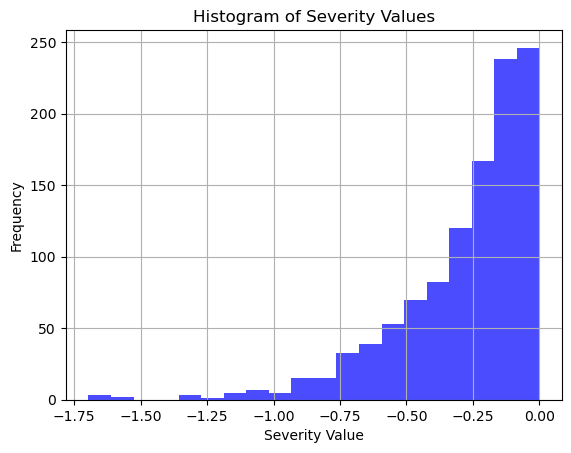

In [159]:
# Drop rows where severity_value is positive (dropping all rows where kndvi of control pixel is lower than kndvi of burned pixel)
df_burned_nonan_kndvi_no_negative_severity = df_burned_nonan_kndvi.loc[df_burned_nonan_kndvi['severity_value'] <= 0]

# Display the DataFrame after dropping rows
df_burned_nonan_kndvi_no_negative_severity

import matplotlib.pyplot as plt

# Plot histogram for severity_value column
plt.hist(df_burned_nonan_kndvi_no_negative_severity['severity_value'], bins=20, color='blue', alpha=0.7)
plt.xlabel('Severity Value')
plt.ylabel('Frequency')
plt.title('Histogram of Severity Values')
plt.grid(True)
plt.show()


In [162]:
df_burned_nonan_kndvi_no_negative_severity_values_classes = df_burned_nonan_kndvi_no_negative_severity

# Calculate quantiles to define severity classes
quantiles = df_burned_nonan_kndvi_no_negative_severity_values_classes['severity_value'].quantile([0.3333, 0.6666])

# Function to assign severity class based on severity value (reversed order)
def assign_severity_class(severity_value):
    if severity_value <= quantiles.iloc[0]:
        return 'High'
    elif severity_value <= quantiles.iloc[1]:
        return 'Medium'
    else:
        return 'Low'

# Add a new column to the DataFrame indicating severity class
df_burned_nonan_kndvi_no_negative_severity_values_classes['severity_class'] = df_burned_nonan_kndvi_no_negative_severity_values_classes['severity_value'].apply(assign_severity_class)

# Print the first few rows to verify the new column
df_burned_nonan_kndvi_no_negative_severity_values_classes


C:\Users\annav\AppData\Local\Temp\ipykernel_22388\638861093.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_burned_nonan_kndvi_no_negative_severity_values_classes['severity_class'] = df_burned_nonan_kndvi_no_negative_severity_values_classes['severity_value'].apply(assign_severity_class)


,burned_lat,burned_lon,control_lat,control_lon,last_burn,burned_kndvi,control_kndvi,severity_value,severity_class
0,50.125,-123.375,50.125,-122.625,2015-08-01,2.066931,2.7153573,-0.648426,High
1,50.125,-117.625,50.125,-118.375,2014-10-01,3.2552948,3.4985807,-0.243286,Medium
3,50.125,-105.125,50.125,-105.375,2015-05-01,1.4570912,1.5974169,-0.140326,Medium
5,50.125,-103.875,50.125,-103.625,2014-05-01,1.6484766,1.6839926,-0.035516,Low
6,50.125,-103.375,50.125,-103.625,2015-09-01,1.8659716,1.9131209,-0.047149,Low
...,...,...,...,...,...,...,...,...,...
1574,67.375,-144.875,67.375,-144.625,2015-07-01,2.6895885,2.6944537,-0.004865,Low
1575,67.375,-143.375,67.125,-142.375,2015-08-01,2.5938985,2.6351717,-0.041273,Low
1577,67.375,-134.875,67.125,-135.125,2014-07-01,2.3339522,2.6225474,-0.288595,Medium
1578,67.375,-134.625,67.375,-134.375,2014-07-01,2.39625,2.5160825,-0.119833,Low


In [163]:
df_high_severity = df_burned_nonan_kndvi_no_negative_severity_values_classes[df_burned_nonan_kndvi_no_negative_severity_values_classes['severity_class'] == 'High']

df_high_severity


,burned_lat,burned_lon,control_lat,control_lon,last_burn,burned_kndvi,control_kndvi,severity_value,severity_class
0,50.125,-123.375,50.125,-122.625,2015-08-01,2.066931,2.7153573,-0.648426,High
10,50.125,-100.875,50.125,-101.125,2014-05-01,2.1060429,2.4535627,-0.347520,High
11,50.125,-100.625,50.375,-101.125,2014-05-01,1.8949196,2.2280247,-0.333105,High
14,50.125,-99.375,50.875,-99.125,2014-05-01,2.3577938,2.875993,-0.518199,High
70,51.125,-99.625,51.125,-99.875,2014-05-01,1.7538838,2.0671928,-0.313309,High
...,...,...,...,...,...,...,...,...,...
1528,65.875,-153.125,65.625,-154.125,2015-08-01,2.1346822,2.8165233,-0.681841,High
1532,65.875,-151.375,65.625,-151.375,2015-07-01,1.8249633,2.2410562,-0.416093,High
1544,66.125,-154.875,66.125,-155.375,2015-08-01,2.148611,2.8509336,-0.702322,High
1562,66.875,-143.625,66.375,-143.625,2015-07-01,2.4588447,2.7891238,-0.330279,High


In [173]:
df_high_severity_airtemp = df_high_severity

ds_burned_control = xr.open_dataset('monthly_data_earth_cube_with_burned_and_control_pixels.nc')

# Create empty lists to store burned and control pixel severities
burned_airtemp_values = []
control_airtemp_values = []

# für jede zeile im dataframe schau die koordinaten für burned und control pixel an 

# Loop through all rows of the dataframe (through all burned pixels with high fire severity)
for i in df_high_severity_airtemp.index:
    burned_lat = df_high_severity_airtemp.at[i, 'burned_lat']
    burned_lon = df_high_severity_airtemp.at[i, 'burned_lon']
    control_lat = df_high_severity_airtemp.at[i, 'control_lat']
    control_lon = df_high_severity_airtemp.at[i, 'control_lon']

    # Extract last burn time as datetime object
    last_burn_date = df_high_severity_airtemp.at[i, 'last_burn']

    # Sutract 1 year to the last burn time
    previous_year_date = last_burn_date.replace(year=last_burn_date.year - 1)

    # Add 24 months to the last burn time
    next_year_date = last_burn_date.replace(year=last_burn_date.year + 2)

    # Look up mean of burned and control pixel air_temp values over the 24 months after last burn
    burned_airtemp = ds_burned_control['air_temperature_2m'].sel(time=slice(previous_year_date, next_year_date), lat=burned_lat, lon=burned_lon).values
    control_airtemp = ds_burned_control['air_temperature_2m'].sel(time=slice(previous_year_date, next_year_date), lat=control_lat, lon=control_lon).values


    # Append severity values to the respective lists
    burned_airtemp_values.append(burned_airtemp)
    control_airtemp_values.append(control_airtemp)

# Add the lists of severity values to the DataFrame as new columns
df_high_severity_airtemp['burned_airtemp_24month_mean'] = burned_airtemp_values
df_high_severity_airtemp['control_airtemp_24month_mean'] = control_airtemp_values

# Save DataFrame with severity values to a new CSV file
#df_burned_nonan.to_csv('burned_control_kndvi.csv', index=False)
# print(df_burned_nonan)

df_high_severity_airtemp
    

C:\Users\annav\AppData\Local\Temp\ipykernel_22388\2416130105.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_high_severity_airtemp['burned_airtemp_24month_mean'] = burned_airtemp_values
C:\Users\annav\AppData\Local\Temp\ipykernel_22388\2416130105.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_high_severity_airtemp['control_airtemp_24month_mean'] = control_airtemp_values


,burned_lat,burned_lon,control_lat,control_lon,last_burn,burned_kndvi,control_kndvi,severity_value,severity_class,burned_airtemp,control_airtemp,burned_airtemp_24month_mean,control_airtemp_24month_mean
0,50.125,-123.375,50.125,-122.625,2015-08-01,2.066931,2.7153573,-0.648426,High,3.369644,3.6343708,"[15.316304, 10.253877, 4.8448753, -4.0828648, ...","[15.738224, 10.269884, 4.7200565, -4.3255873, ..."
10,50.125,-100.875,50.125,-101.125,2014-05-01,2.1060429,2.4535627,-0.347520,High,3.9059908,4.0435767,"[11.229176, 17.34257, 17.988066, 17.380419, 15...","[11.230972, 17.323627, 18.095964, 17.525593, 1..."
11,50.125,-100.625,50.375,-101.125,2014-05-01,1.8949196,2.2280247,-0.333105,High,3.7546334,3.7005737,"[11.087606, 17.299034, 17.829823, 17.210434, 1...","[11.021734, 17.045689, 17.795694, 17.385468, 1..."
14,50.125,-99.375,50.875,-99.125,2014-05-01,2.3577938,2.875993,-0.518199,High,4.121575,4.1758356,"[10.699169, 17.631178, 18.165712, 17.435266, 1...","[10.277044, 17.92062, 18.75363, 18.373127, 15...."
70,51.125,-99.625,51.125,-99.875,2014-05-01,1.7538838,2.0671928,-0.313309,High,3.979768,3.8928518,"[9.911204, 17.58259, 18.649916, 18.246296, 15....","[10.146127, 17.280111, 18.328634, 17.998066, 1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1528,65.875,-153.125,65.625,-154.125,2015-08-01,2.1346822,2.8165233,-0.681841,High,-2.3462427,-2.2179039,"[13.662611, 5.1780605, -4.10172, -13.051603, -...","[13.444387, 4.9870443, -4.5498724, -12.174625,..."
1532,65.875,-151.375,65.625,-151.375,2015-07-01,1.8249633,2.2410562,-0.416093,High,-3.2505257,-3.141715,"[12.157479, 12.429534, 4.0414534, -7.03318, -1...","[11.981351, 12.264679, 4.038804, -7.1759987, -..."
1544,66.125,-154.875,66.125,-155.375,2015-08-01,2.148611,2.8509336,-0.702322,High,-1.7750915,-1.7628522,"[14.417717, 5.7008343, -3.8084846, -12.5396385...","[14.448025, 5.814084, -3.845186, -12.81766, -1..."
1562,66.875,-143.625,66.375,-143.625,2015-07-01,2.4588447,2.7891238,-0.330279,High,-2.104043,-2.1253622,"[16.05488, 14.543385, 6.615128, -5.3542995, -1...","[16.279528, 14.935846, 7.096776, -5.8920417, -..."


In [174]:
burned_airtemp = ds_burned_control['air_temperature_2m'].sel(time=slice(previous_year_date, next_year_date), lat=burned_lat, lon=burned_lon).values
burned_airtemp

array([ 13.174167 ,  13.436029 ,   5.9419928,  -0.3158071, -14.623077 ,
       -29.005745 , -26.498266 , -27.106287 , -21.895443 , -12.2339735,
         1.8054492,  12.579698 ,  15.992412 ,   9.977221 ,   3.714308 ,
        -4.4724784, -18.655052 , -22.20829  , -25.272417 , -26.872    ,
       -19.116976 ,  -9.897364 ,   2.6085463,  11.7136755,  12.528644 ,
        11.676211 ,   4.2656984,  -4.2854424, -14.523668 , -21.959599 ,
       -20.379871 , -24.901789 , -19.421711 , -12.678757 ,   3.0883913,
        11.573282 ,  14.946805 ], dtype=float32)

In [158]:
# Print minimum and maximum values of the severity_value column
min_severity = df_burned_nonan_kndvi_no_negative_severity['severity_value'].min()
max_severity = df_burned_nonan_kndvi_no_negative_severity['severity_value'].max()

print("Minimum Severity Value:", min_severity)
print("Maximum Severity Value:", max_severity)


Minimum Severity Value: -1.696345329284668
Maximum Severity Value: 0.0
